In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix

In [ ]:
#Globals + hyperparameters
num_features = 595 # 396 (32 features + 34 keypoint values) * 6 frames/sequence
num_classes = 4 # no punch, straight, hook, uppercut

batch_size = 64

In [ ]:
#Loading data
NUM_FEATURES_PER_SEQUENCE = 98

drive.mount('/content/drive')
folderPath = "/content/drive/MyDrive/Year 2/229 ._./Labeled/" #change as appropriate
file_list = [f for f in os.listdir(folderPath)]
Xs = []
Ys = []

dtype = [('column1', 'U10')] + [('column{}'.format(i), float) for i in range(2, num_features + 1)]

for file in file_list:
  temp = np.genfromtxt(f"{folderPath}{file}", delimiter=',', dtype=dtype)
  data = np.array([list(row) for row in temp])
  Xs.append(np.array([row[7:].astype(float) for row in data]))
  Ys.append(np.array([row[6].astype(float).astype(int) for row in data]))

X_nonorm = np.vstack(Xs)
Y = np.hstack(Ys)
numSamples = len(X_nonorm)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
#Normalizing
mean = np.mean(X_nonorm, axis=0)
std_dev = np.std(X_nonorm, axis=0)
normalized_data = (X_nonorm - mean) / std_dev

X_nonorm = np.reshape(X_nonorm, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))
normalized_data = np.reshape(normalized_data, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))

normalized_data = np.reshape(normalized_data, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))
X_nonorm = np.reshape(X_nonorm, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))

X = normalized_data

for i in range(35,98,2):
  X[:, :, i] = X_nonorm[:, :, i]

In [40]:
#For softmax
X = np.reshape(X, (numSamples, NUM_FEATURES_PER_SEQUENCE * 6))

In [44]:
# #80 20 train test
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss_train_test.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

class_counts = tf.math.bincount(Y)
weights = {class_label: numSamples / count for class_label, count in enumerate(class_counts)}

In [ ]:
#Building softmax model
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(num_features - 7,)))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.output_shape

(None, 4)

In [58]:
#Building RNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=128, activation='relu', input_shape=(6, NUM_FEATURES_PER_SEQUENCE)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.output_shape

(None, 4)

In [ ]:
#Softmax Compilation + Fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_onehot, epochs=600, batch_size=numSamples, verbose=1, class_weight=weights)

Epoch 1/600
1/1 [==============================] - 1s 1s/step - loss: 8.0309 - accuracy: 0.4852
Epoch 2/600
1/1 [==============================] - 0s 101ms/step - loss: 7.7612 - accuracy: 0.4648
Epoch 3/600
1/1 [==============================] - 0s 126ms/step - loss: 7.5258 - accuracy: 0.4379
Epoch 4/600
1/1 [==============================] - 0s 141ms/step - loss: 7.3251 - accuracy: 0.4078
Epoch 5/600
1/1 [==============================] - 0s 135ms/step - loss: 7.1567 - accuracy: 0.3729
Epoch 6/600
1/1 [==============================] - 0s 164ms/step - loss: 7.0148 - accuracy: 0.3344
Epoch 7/600
1/1 [==============================] - 0s 152ms/step - loss: 6.8921 - accuracy: 0.2994
Epoch 8/600
1/1 [==============================] - 0s 154ms/step - loss: 6.7834 - accuracy: 0.2661
Epoch 9/600
1/1 [==============================] - 0s 106ms/step - loss: 6.6864 - accuracy: 0.2413
Epoch 10/600
1/1 [==============================] - 0s 120ms/step - loss: 6.6003 - accuracy: 0.2245
Epoch 11/600

In [59]:
#RNN Compilation + fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=150, batch_size=512, verbose=1, class_weight=weights)

Epoch 1/150
43/43 [==============================] - 4s 33ms/step - loss: 6.3737 - accuracy: 0.1620
Epoch 2/150
43/43 [==============================] - 1s 33ms/step - loss: 5.6134 - accuracy: 0.3540
Epoch 3/150
43/43 [==============================] - 1s 26ms/step - loss: 5.3992 - accuracy: 0.4538
Epoch 4/150
43/43 [==============================] - 1s 20ms/step - loss: 5.2534 - accuracy: 0.4623
Epoch 5/150
43/43 [==============================] - 1s 20ms/step - loss: 5.1390 - accuracy: 0.4895
Epoch 6/150
43/43 [==============================] - 1s 20ms/step - loss: 5.0294 - accuracy: 0.5047
Epoch 7/150
43/43 [==============================] - 1s 20ms/step - loss: 4.9229 - accuracy: 0.5330
Epoch 8/150
43/43 [==============================] - 1s 20ms/step - loss: 4.8325 - accuracy: 0.5520
Epoch 9/150
43/43 [==============================] - 1s 20ms/step - loss: 4.7496 - accuracy: 0.5618
Epoch 10/150
43/43 [==============================] - 1s 19ms/step - loss: 4.6739 - accuracy: 0.5675

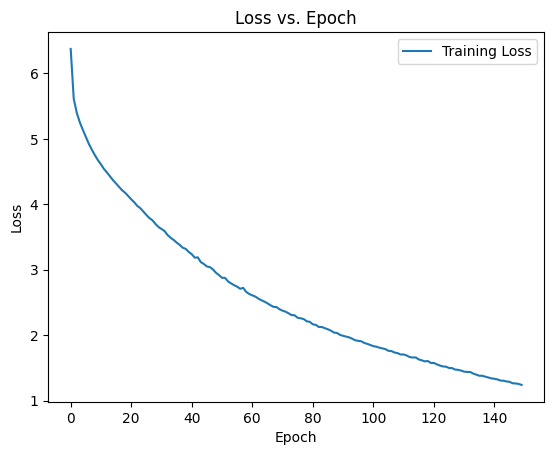

In [60]:
#Visualization
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

In [ ]:
#Softmax evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

balanced_acc = balanced_accuracy_score(y_test, y_pred_classes)
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Loss: {loss}, Accuracy: {accuracy}, Balanced Accuracy: {balanced_acc}')

172/172 [==============================] - 1s 3ms/step - loss: 1.0593 - accuracy: 0.6300
Loss: 1.0592678785324097, Accuracy: 0.630007266998291, Balanced Accuracy: 0.4357606267819109


In [61]:
#RNN evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

balanced_acc = balanced_accuracy_score(y_true, y_pred_classes)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}, Balanced Accuracy: {balanced_acc}')

172/172 [==============================] - 1s 4ms/step - loss: 0.7634 - accuracy: 0.7454
Loss: 0.7633998990058899, Accuracy: 0.7454479336738586, Balanced Accuracy: 0.48846469724285346
